In [11]:
import os

import numpy as np

from astropy.io import fits, ascii as asc
from matplotlib import pyplot as plt
%matplotlib inline

from utilities_az import spectroscopy as spec

In [12]:
DATA_DIR = '../data/spectra/gmos/'

In [13]:
flist2 = ['comb20160610_R400.fits','comb20160609_R400.fits',  'comb20160612_B600.fits']

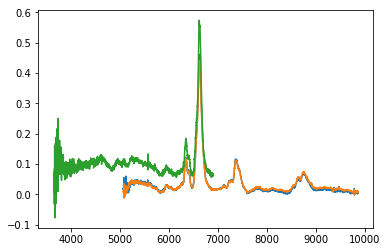

In [14]:
for ifile in flist2:
    ofile = fits.open(os.path.join(DATA_DIR, ifile))
    flux = ofile[0].data
    pix = np.arange(len(flux))+1
    wl = spec.calc_wavelength(ofile[0].header, pix)
    plt.plot(wl, flux)

In [15]:
ofile_red = fits.open(os.path.join(DATA_DIR, flist2[0]))
flux_red = ofile_red[0].data
pix_red = np.arange(len(flux_red))+1
wl_red = spec.calc_wavelength(ofile_red[0].header, pix_red)

ofile_blue = fits.open(os.path.join(DATA_DIR, flist2[2]))
flux_blue = ofile_blue[0].data
pix_blue = np.arange(len(flux_blue))+1
wl_blue = spec.calc_wavelength(ofile_blue[0].header, pix_blue)

In [16]:
wl_min = 6100
wl_max = 6800
offset = np.arange(0.04, 0.08, 0.001)
chisq = []

red_indx = (wl_red>wl_min)&(wl_red<wl_max)
wl_red_overlap = wl_red[red_indx]
flux_red_overlap = flux_red[red_indx]
flux_blue_interp = np.interp(wl_red_overlap, wl_blue, flux_blue)
for ioffset in offset:
    chisq.append(np.sum((flux_blue_interp-ioffset - flux_red_overlap)**2))

chisq = np.array(chisq)
min_indx = np.argmin(chisq)
best_offset = offset[min_indx]
print(best_offset)

0.04900000000000001


(0.01, 0.5)

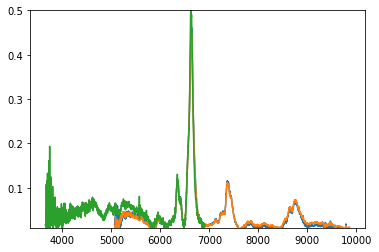

In [17]:
ofile_blue = fits.open(os.path.join(DATA_DIR, flist2[2]))
flux_blue = ofile_blue[0].data
pix_blue = np.arange(len(flux_blue))
wl_blue = spec.calc_wavelength(ofile_blue[0].header, pix_blue)
spec_blue = spec.spectrum1d(wl_blue, flux_blue)

ofile_red = fits.open(os.path.join(DATA_DIR, flist2[1]))
flux_red = ofile_red[0].data
pix_red = np.arange(len(flux_red))
wl_red = spec.calc_wavelength(ofile_red[0].header, pix_red)
spec_red = spec.spectrum1d(wl_red, flux_red)

scale_blue_spec = spec.spectrum1d(spec_blue.wave, spec_blue.flux-best_offset)
scale_blue_spec = spec.scale_spectra(scale_blue_spec, spec_red, wlmin=wl_min, wlmax = wl_max)
for ifile in flist2[:2]:
    ofile = fits.open(os.path.join(DATA_DIR, ifile))
    flux = ofile[0].data
    pix = np.arange(len(flux))+1
    wl = spec.calc_wavelength(ofile[0].header, pix)
    plt.plot(wl, flux)
plt.plot(scale_blue_spec.wave, scale_blue_spec.flux)
#plt.axvline(6000, color='k')
#plt.axvline(6850, color='k')
plt.ylim(10**-2, 0.5)

## Test merging

In [18]:
redshift = 0.0069
files = ['comb20160609_R400.fits', 'comb20160610_R400.fits', 'comb20160612_B600.fits']
ofile1 = fits.open(os.path.join(DATA_DIR, files[0]))
ofile2 = fits.open(os.path.join(DATA_DIR, files[1]))
ofile3 = fits.open(os.path.join(DATA_DIR, files[2]))
flux1 = ofile1[0].data#*10**-15
flux2 = ofile2[0].data#*10**-15
flux3 = ofile3[0].data#*10**-15
pixels1 = np.arange(len(flux1))+1
pixels2 = np.arange(len(flux2))+1
pixels3 = np.arange(len(flux3))+1
wl1 = spec.calc_wavelength(ofile1[0].header, pixels1)
wl2 = spec.calc_wavelength(ofile2[0].header, pixels2)
wl3 = spec.calc_wavelength(ofile3[0].header, pixels3)
#deredshift
rest_wl1 = spec.apply_redshift(wl1, redshift=redshift)
rest_wl2 = spec.apply_redshift(wl2, redshift=redshift)
rest_wl3 = spec.apply_redshift(wl3, redshift=redshift)
#scale and merge
obs_spec1 = spec.spectrum1d(rest_wl1, flux1)
obs_spec2 = spec.spectrum1d(rest_wl2, flux2)
obs_spec3 = spec.spectrum1d(rest_wl3, flux3)
obs_spec2_interp = spec.spectrum1d(obs_spec1.wave, np.interp(obs_spec1.wave, obs_spec2.wave, obs_spec2.flux))
scale_obs_spec3 = spec.spectrum1d(obs_spec3.wave, obs_spec3.flux-best_offset)
scale_obs_spec3_interp = spec.spectrum1d(obs_spec1.wave, np.interp(obs_spec1.wave, scale_obs_spec3.wave, scale_obs_spec3.flux))
overlap_min = 6000
overlap_max = scale_obs_spec3.wave[-5]
seg1_indx = scale_obs_spec3.wave<overlap_min
seg1_wl = scale_obs_spec3.wave[seg1_indx]
seg1_flux = scale_obs_spec3.flux[seg1_indx] 
seg2_indx = (obs_spec2.wave>=overlap_min)&(obs_spec2.wave<=overlap_max)
seg2_wl = obs_spec1.wave[seg2_indx]
seg2_flux = np.mean(np.vstack((obs_spec1.flux[seg2_indx], obs_spec2_interp.flux[seg2_indx], scale_obs_spec3_interp.flux[seg2_indx])), axis=0)
seg3_indx = obs_spec1.wave>overlap_max
seg3_wl = obs_spec1.wave[seg3_indx]
seg3_flux = np.mean(np.vstack((obs_spec1.flux[seg3_indx], obs_spec2_interp.flux[seg3_indx])), axis=0)
merge_spec = spec.spectrum1d(np.hstack((seg1_wl, seg2_wl, seg3_wl)), np.hstack((seg1_flux, seg2_flux, seg3_flux)))

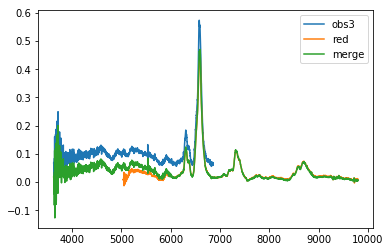

In [19]:
plt.plot(obs_spec3.wave, obs_spec3.flux, label='obs3')
plt.plot(obs_spec1.wave, obs_spec1.flux, label='red')
plt.plot(np.hstack((seg1_wl, seg2_wl, seg3_wl)), np.hstack((seg1_flux, seg2_flux, seg3_flux)), label='merge')
plt.legend()

In [24]:
print( obs_spec1.wave.min(), obs_spec1.wave.max(),np.median(obs_spec1.wave[1:]-obs_spec1.wave[:-1]))
print( obs_spec3.wave.min(), obs_spec3.wave.max(),np.median(obs_spec3.wave[1:]-obs_spec3.wave[:-1]))

5030.644994848059 9797.522097527175 1.491046951104181
3629.189791609793 6857.233914117507 0.9966175123518042


In [27]:
fits.getheader(os.path.join(DATA_DIR, flist2[0]))

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 3198 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
OBJECT  = 'ASASSN15oz'         / Name of the object observed                    
DATE    = '2018-10-30T19:49:24' / Date FITS file was generated                  
IRAF-TLM= '2018-10-30T19:49:24' / Time of last modification                     
FIXPIX  = 'Oct 29 21:16 Bad pixel file is tmpbpm131747_4163.pl'                 
CTYPE1  = 'LINEAR  '           / R.A. in tangent plane projection               
CRPIX1  =                   1. / Ref pix of axis 1                              
CRVAL1  =     5065.226074218